<a href="https://colab.research.google.com/github/StephenTGibson/COMP527-colabNotebooks/blob/main/Neural_Network_Tutorial_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP534 Lab
## Neural Network from Scratch with PyTorch

In this tutorial we will implement a simple neural network from scratch using PyTorch and Google Colab. The idea is to teach you the basics of PyTorch and how it can be used to implement a neural network from scratch. I will go over some of the basic functionalities available in PyTorch that will allow you to build your customized neural networks.

In [ ]:
# Firstly install some essential packages
!pip3 install torch torchvision

In [ ]:
## The usual imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

## print out the pytorch version used
print(torch.__version__)

1.10.0+cu111


# Regression

Firstly lets generate some fake data. We use the following code, where the distribution of generated data points is a simple quadratic function with some random noise. Recall the regression problem, we train a neural network to fit data with the best hyper-plane which goes through the points.

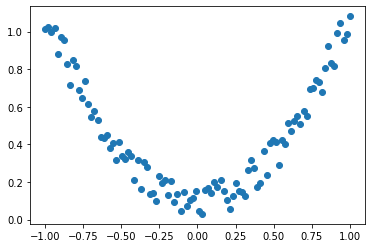

In [ ]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# Display
plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In below, you can print to see the dimension of x using `print(x.shape)`. It should be [100, 1], which means $x\in \mathbb{R}^{100\times 1}$. Same for y.

You will notice in below, the datatype of x is not a numpy array, it is a __Tensor__. A PyTorch __Tensor__ is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. Behind the scenes, Tensors can keep track of a computational graph and gradients, but they’re also useful as a generic tool for scientific computing. 

So most datatype undergo PyTorch framework, we use tensor instead numpy, almost exact same command on numpy can be transfered to tensor, i.e. Tensor is a PyTorch version numpy array.

In [ ]:
print(x.shape) # print dimension
print(type(x)) # print datatype

torch.Size([100, 1])
<class 'torch.Tensor'>


## Define a neural network using PyTorch

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every nn.Module subclass implements the operations on input data in the forward method.

- `n_feature`: the input data dimension (number of neurons in first layer)
- `n_hidden`: the hidden layer dimension (number of neurons in hidden layer)
- `n_output`: the output dimension (number of neurons in output layer)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

We then instantiate the network, one can print the network structure by `print(net)`

In [ ]:
net = Net(n_feature=1, n_hidden=10, n_output=1) # Instantiate the network
print(net)  # net architecture

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


## Hyperparameters
Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates. You can refer to this [link](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) about fine tuning.

Here we define the following hyperparameters:
-  `learning_rate`: How much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

- `epochs`: the number times to iterate over the dataset

In [ ]:
learning_rate = 2e-1
epochs = 100

## Optimizer
Optimization is the process of adjusting model parameters to reduce model error in each training step. All optimization logic is encapsulated in the `optimizer` object. Here, we use the simplest SGD optimizer.

## Loss function
Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. The input of loss function is usually the predicted label from neural network and the true label from dataset. Here, we use the Mean Square Error (MSE) for regression problem.

In [ ]:
# Initialize the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
# Initialize the loss function
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# Training

Inside the training loop, optimization happens in four steps:
- Make the prediction with `net(x)` or `net.forward(x)`, this generate the predicted label `y_prediction`. We calulate the loss between prediction `y_prediction` and true label `y` by `loss_func(y_prediction, y)`.
- Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
- Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
- Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

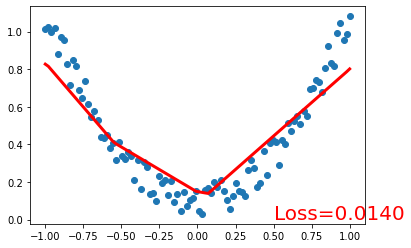

In [ ]:
for t in range(epochs):
    y_prediction = net(x)     # input x and predict based on x

    loss = loss_func(y_prediction, y)   # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    # Visualization
    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), y_prediction.data.numpy(), 'r-', lw=3)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        clear_output(wait=True)
        plt.show()
        plt.pause(0.5)


# Classification
Above is how you define and train the neural network for regression problem. Another huge part of machine learning problem is classifcation problem, where the output variable is a category, such as “red” or “blue” or “disease” and “no disease”. A classification model attempts to draw some conclusion from observed values. Given one or more inputs a classification model will try to predict the value of one or more outcomes. 

Similar to above, lets draw some data first. Below we have two classes of datapoints, green for class 0, red for class 1, two cluster of datapoints are sampled two different gaussian distribution with different distribution parameters. However, the neural network don't know which data is drawn from which distribution, and will learn to classify these data.

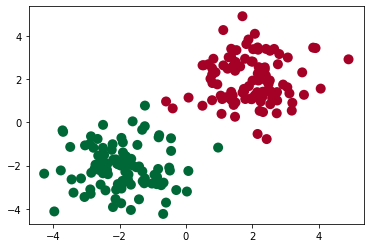

In [ ]:
# make fake data
n_data = torch.ones(100, 2)
x0 = torch.normal(2*n_data, 1)      # class0 x data (tensor), shape=(100, 2)
y0 = torch.zeros(100)               # class0 y data (tensor), shape=(100, 1)
x1 = torch.normal(-2*n_data, 1)     # class1 x data (tensor), shape=(100, 2)
y1 = torch.ones(100)                # class1 y data (tensor), shape=(100, 1)
x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # shape (200, 2) FloatTensor = 32-bit floating
y = torch.cat((y0, y1), ).type(torch.LongTensor)    # shape (200,) LongTensor = 64-bit integer

plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

Similar to regression problem, we define the network, hyperparameters, optimizer and loss function. Remark that the loss function is different, for classification tasks, we use cross entropy loss instead of MSE loss.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.out(x)
        return x

net = Net(n_feature=2, n_hidden=10, n_output=2)  # define the network
print(net)  # net architecture

learning_rate = 1e-2
epochs = 100

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

Net(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)


## Training
The softmax function is defined as
$$
\text{Softmax}(x_i) = \frac{\exp (x_i)}{\sum_j \exp(x_j)}
$$
the Softmax function can be applied to an n-dimensional input Tensor, rescaling them so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1. When we are evaluating the prediction, we call `F.softmax(out)`, this means we normalize (rescale) the output of two neurons to make them sum to 1, now these two rescaled values can be viewed as the probability of a datapoint is in which class.

With the knowledge of regression, it should be easy for you to figure out how classification works. If you don't understand anything, take a look at the documentation or ask your demonstrators, good luck :-)


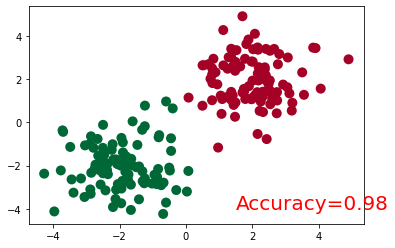

In [ ]:
for t in range(epochs):
    out = net(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if t % 10 == 0 or t in [3, 6]:
        # plot and show learning process
        plt.cla()
        _, prediction = torch.max(F.softmax(out), 1)
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y)/x.shape[0]
        plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        clear_output(wait=True)
        plt.show()
        plt.pause(0.5)